# Data Loading

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Set seeds
np.random.seed(42)
random.seed(42)

In [2]:
df = pd.read_excel('/kaggle/input/malefertilitydataset/DIB dataset and codebook.xlsx')

In [3]:
df.head()

,ID,Age,Religion,Ethnicity,Marital status,Marriage period,No. of children,Educational level,Employment status,Working period,...,JS33,JS34,JS35,JS36,JP1,JP2,JP3,JP4,JP5,JP6
0,1,2,1,1,1,1,1,6,1,4,...,5,4,4,4,4,4,4,2,5,5
1,2,2,1,1,1,2,1,6,1,3,...,5,3,5,5,5,5,4,5,5,5
2,3,2,1,1,1,2,1,6,1,5,...,5,5,5,5,5,5,5,5,5,5
3,4,3,1,1,2,1,2,5,1,5,...,4,5,5,5,2,2,2,4,5,5
4,5,2,1,1,1,1,1,6,1,3,...,5,5,5,5,5,5,5,5,5,5


In [4]:
# Calculate the mean of OS1 to OS35 and assign it to the new column OS
df['JS'] = df.loc[:, 'JS1':'JS36'].sum(axis=1)

def min_max_normalize(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return normalized_column

df['JS_norm'] = min_max_normalize(df['JS'])

#Creating Labels of target column JS

rating = []
for row in df['JS_norm']:
    if row <= 0.5:
        rating.append(0)
    else:
        rating.append(1)
df['Target'] = rating

In [5]:
df.drop(columns=['JS1', 'JS2', 'JS3', 'JS4', 'JS5', 'JS6', 'JS7', 'JS8', 'JS9', 'JS10', 'JS11', 'JS12', 'JS13', 'JS14', 'JS15', 'JS16', 'JS17', 'JS18', 'JS19', 'JS20', 'JS21', 'JS22', 'JS23', 'JS24', 'JS25', 'JS26', 'JS27', 'JS28', 'JS29', 'JS30', 'JS31', 'JS32', 'JS33', 'JS34', 'JS35', 'JS36'], inplace=True)
df = df.drop(columns=['ID', 'JS_norm', 'JS'])
df = df.drop(columns=['JP1', 'JP2', 'JP3', 'JP4', 'JP5', 'JP6'])

In [6]:
df.head()

,Age,Religion,Ethnicity,Marital status,Marriage period,No. of children,Educational level,Employment status,Working period,Household income,...,OS33,OS34,OS35,OS36,OS37,OS38,OS39,OS40,OS41,Target
0,2,1,1,1,1,1,6,1,4,7,...,5,5,5,4,4,4,4,4,4,1
1,2,1,1,1,2,1,6,1,3,4,...,4,5,5,3,2,3,2,3,3,0
2,2,1,1,1,2,1,6,1,5,7,...,4,5,5,3,4,4,3,4,4,1
3,3,1,1,2,1,2,5,1,5,10,...,2,5,4,3,4,4,3,3,3,1
4,2,1,1,1,1,1,6,1,3,5,...,5,5,5,4,4,4,4,4,4,1


In [7]:
df['Target'].value_counts()

Target
1    180
0    129
Name: count, dtype: int64

# Data Splitting

In [8]:
X = df.drop(['Target'], axis=1)  # Features
y = df['Target']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42) 

**Drop Zero Variance**

In [9]:
from sklearn.feature_selection import VarianceThreshold

# Initialize VarianceThreshold with threshold=0 to remove zero-variance features
zero_var_selector = VarianceThreshold(threshold=0)
X_train_reduced = zero_var_selector.fit_transform(X_train)

# Retain only the features that are not zero-variance
retained_features = X_train.columns[zero_var_selector.get_support()]
X_train = pd.DataFrame(X_train_reduced, columns=retained_features)

# Apply the same transformation to X_test
X_test = X_test[retained_features]

print("Features retained after Zero-Variance Elimination: ", retained_features)

# Number of features selected
print("\nNumber of features selected: ", len(retained_features))

Features retained after Zero-Variance Elimination:  Index(['Age', 'Religion', 'Ethnicity', 'Marital status', 'Marriage period',
       'No. of children', 'Educational level', 'Employment status',
       'Working period', 'Household income', 'Sperm quality', 'OS1', 'OS2',
       'OS3', 'OS4', 'OS5', 'OS6', 'OS7', 'OS8', 'OS9', 'OS10', 'OS11', 'OS12',
       'OS13', 'OS14', 'OS15', 'OS16', 'OS17', 'OS18', 'OS19', 'OS20', 'OS21',
       'OS22', 'OS23', 'OS24', 'OS25', 'OS26', 'OS27', 'OS28', 'OS29', 'OS30',
       'OS31', 'OS32', 'OS33', 'OS34', 'OS35', 'OS36', 'OS37', 'OS38', 'OS39',
       'OS40', 'OS41'],
      dtype='object')

Number of features selected:  52


**Outliers Handling**

In [10]:
def replace_outliers_with_median(df):
    for column in df.select_dtypes(include=[np.number]):  # Only apply to numeric columns
        mean = df[column].mean()
        std_dev = df[column].std()
        lower_bound = mean - 2 * std_dev
        upper_bound = mean + 2 * std_dev
        median = df[column].median()
        
        # Replace values outside the range with the median
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median, df[column])
    
    return df

# Usage
X_train = replace_outliers_with_median(X_train)

**rfcv**

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42)

# Initialize RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')

# Fit RFECV
rfecv.fit(X_train, y_train)

# Selected features after RFECV
X_train_selected = X_train.loc[:, rfecv.support_]
X_test_selected = X_test.loc[:, rfecv.support_]  # Assuming you have X_test for validation

# Retrain the model using the selected features
model.fit(X_train_selected, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

              Feature  Importance
14               OS15    0.083271
18               OS19    0.077693
16               OS17    0.046808
9                 OS8    0.046521
2    Household income    0.043235
17               OS18    0.042465
15               OS16    0.036694
22               OS23    0.030226
12               OS12    0.029876
32               OS39    0.029822
27               OS33    0.028973
7                 OS6    0.028679
29               OS36    0.027798
6                 OS5    0.026677
26               OS30    0.026492
31               OS38    0.026173
19               OS20    0.025274
21               OS22    0.024912
4                 OS1    0.024909
8                 OS7    0.023462
3       Sperm quality    0.023128
13               OS14    0.022464
25               OS29    0.021637
30               OS37    0.021573
20               OS21    0.021395
24               OS28    0.021343
28               OS35    0.020899
5                 OS3    0.019990
0     Marriage

In [12]:
# Extract the top 28 feature names as a list
top_27_features_list = importances_df.head(27)['Feature'].tolist()

print(top_27_features_list)

['OS15', 'OS19', 'OS17', 'OS8', 'Household income', 'OS18', 'OS16', 'OS23', 'OS12', 'OS39', 'OS33', 'OS6', 'OS36', 'OS5', 'OS30', 'OS38', 'OS20', 'OS22', 'OS1', 'OS7', 'Sperm quality', 'OS14', 'OS29', 'OS37', 'OS21', 'OS28', 'OS35']


In [13]:
# Combine and deduplicate feature names
selected_features = ['OS15', 'OS19', 'OS17', 'OS8', 'Household income', 'OS18', 'OS16', 
                     'OS23', 'OS12', 'OS39', 'OS33', 'OS6', 'OS36', 'OS5', 'OS30', 'OS38', 
                     'OS20', 'OS22', 'OS1', 'OS7', 'Sperm quality', 'OS14', 'OS29', 'OS37',
                     'OS21', 'OS28', 'OS35']

# Filter X_train and X_test to keep only these features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Shape of X_train after selection: {X_train_selected.shape}")
print(f"Shape of X_test after selection: {X_test_selected.shape}")

Shape of X_train after selection: (247, 27)
Shape of X_test after selection: (62, 27)


In [14]:
X_train = X_train_selected
X_test = X_test_selected

# Model Selection

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Hyperparameter Optimization - Randomized Search CV

In [16]:
# Define model hyperparameter spaces
param_distributions = {
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'LGBMClassifier': {
        'num_leaves': [31, 62, 127],
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [100, 200, 300]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 6, 9]
    },
    
    'LogisticRegression': {
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'max_iter': [100, 200, 500, 1000], 
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Instantiate models
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LGBMClassifier': LGBMClassifier(verbose=-1),
    'XGBClassifier': XGBClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

best_params = {}

for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model_name}")
    clf = RandomizedSearchCV(model, param_distributions[model_name], n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    best_params[model_name] = clf.best_params_
    print(f"Best parameters for {model_name}: {clf.best_params_}")

Running RandomizedSearchCV for DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for DecisionTreeClassifier: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 50}
Running RandomizedSearchCV for RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Running RandomizedSearchCV for AdaBoostClassifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for AdaBoostClassifier: {'n_estimators': 50, 'learning_rate': 0.1}
Running RandomizedSearchCV for LGBMClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LGBMClassifier: {'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.1}
Running RandomizedSearchCV for XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBClassifier: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.01}
Running RandomizedSearchCV for LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters for LogisticRegression: {'solver': 'lbfgs', 'max_iter': 100, 'C': 0.615848211066026}
Running RandomizedSearchCV for SVC
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for SVC: {'kernel': 'rbf', 'C': 1}
Running RandomizedSearchCV for KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for KNeighborsClassifier: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}


# Model Training and Evaluation

Classification Report for DecisionTreeClassifier:
               precision    recall  f1-score   support

           0     0.6429    0.6923    0.6667        26
           1     0.7647    0.7222    0.7429        36

    accuracy                         0.7097        62
   macro avg     0.7038    0.7073    0.7048        62
weighted avg     0.7136    0.7097    0.7109        62

ROC-AUC Score for DecisionTreeClassifier: 0.7265
__________________________

Classification Report for RandomForestClassifier:
               precision    recall  f1-score   support

           0     0.7692    0.7692    0.7692        26
           1     0.8333    0.8333    0.8333        36

    accuracy                         0.8065        62
   macro avg     0.8013    0.8013    0.8013        62
weighted avg     0.8065    0.8065    0.8065        62

ROC-AUC Score for RandomForestClassifier: 0.8910
__________________________

Classification Report for AdaBoostClassifier:
               precision    recall  f1-score

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for LogisticRegression:
               precision    recall  f1-score   support

           0     0.6897    0.7692    0.7273        26
           1     0.8182    0.7500    0.7826        36

    accuracy                         0.7581        62
   macro avg     0.7539    0.7596    0.7549        62
weighted avg     0.7643    0.7581    0.7594        62

ROC-AUC Score for LogisticRegression: 0.8536
__________________________

Classification Report for SVC:
               precision    recall  f1-score   support

           0     0.7600    0.7308    0.7451        26
           1     0.8108    0.8333    0.8219        36

    accuracy                         0.7903        62
   macro avg     0.7854    0.7821    0.7835        62
weighted avg     0.7895    0.7903    0.7897        62

ROC-AUC Score for SVC: 0.8910
__________________________

Classification Report for KNeighborsClassifier:
               precision    recall  f1-score   support

           0     0.7500    0.692

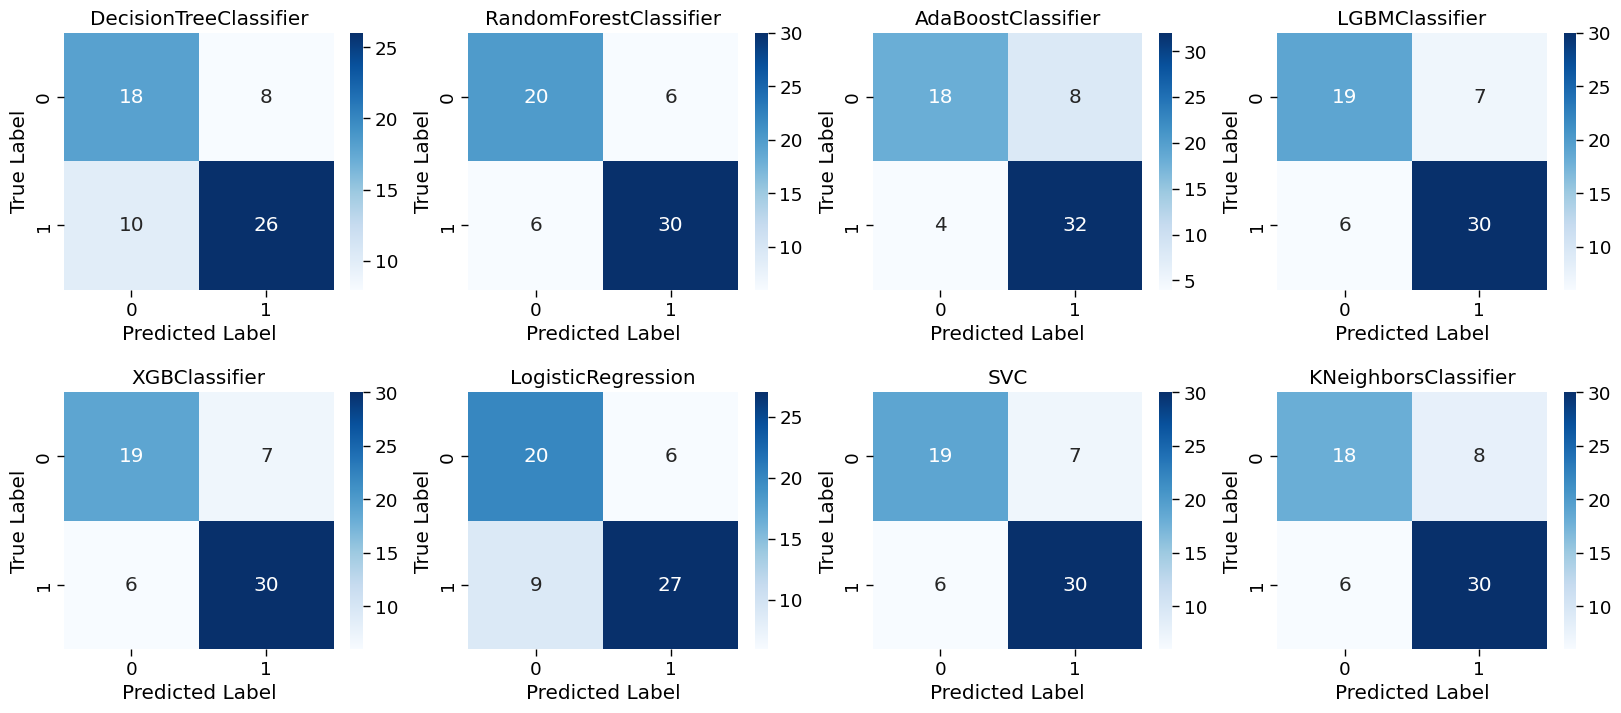

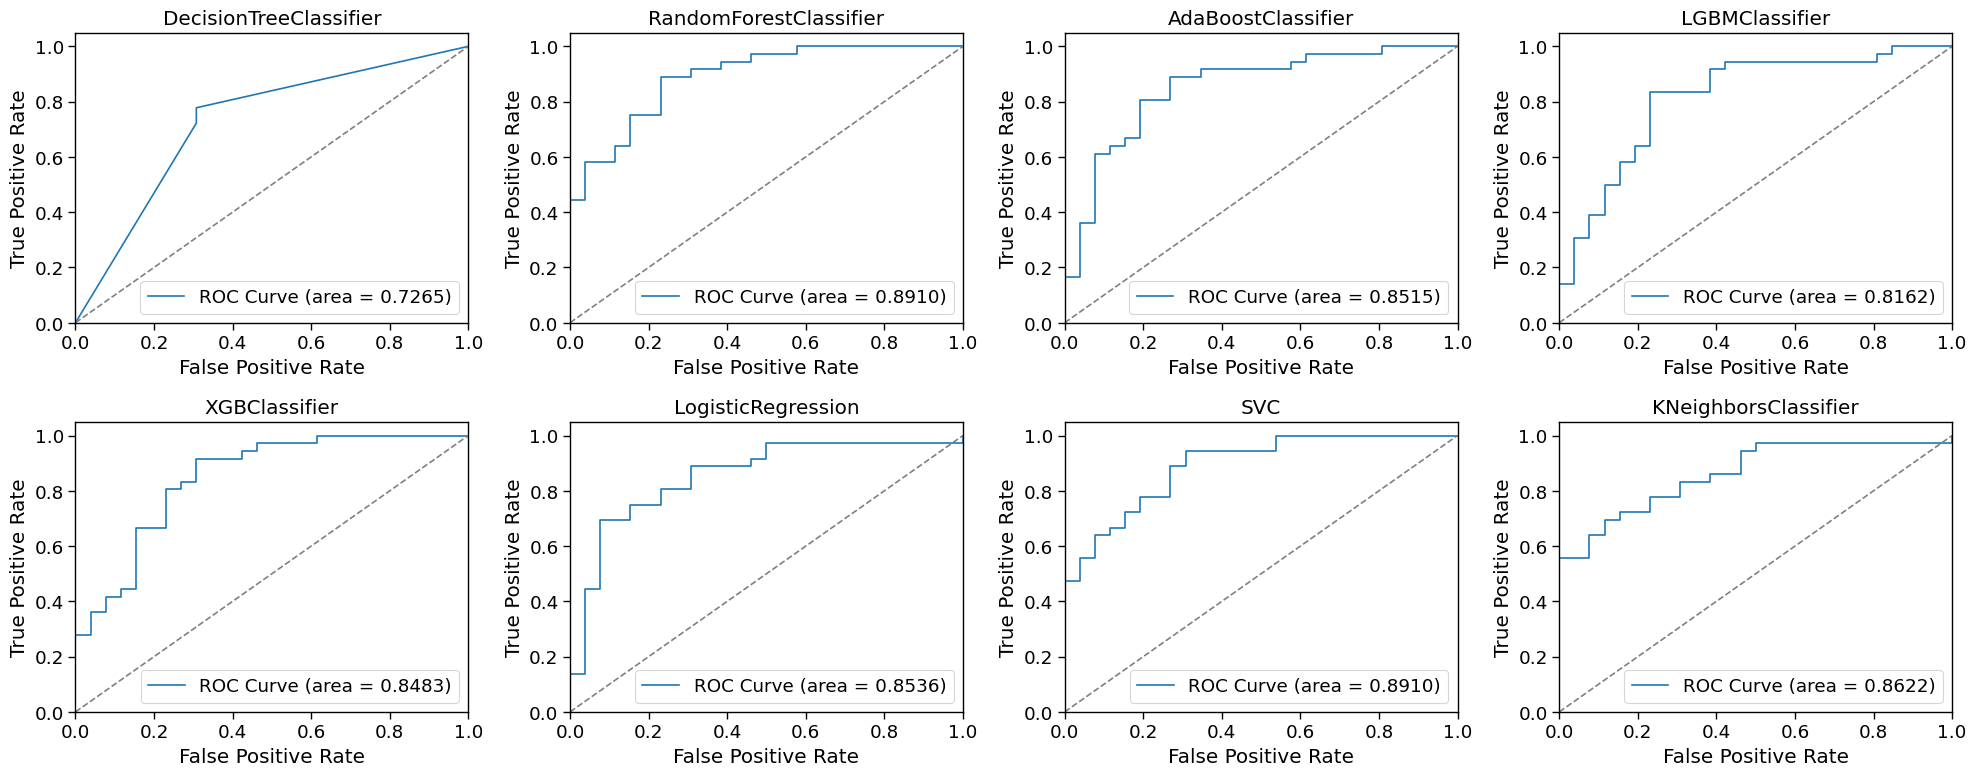

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Adjust plot settings for better readability
sns.set_context("paper", font_scale=1.5)

# Create subplots for confusion matrices and ROC curves
fig_conf_matrix, axes_conf_matrix = plt.subplots(2, 4, figsize=(20, 8))  # 4 per row, 2 rows
plt.subplots_adjust(hspace=0.4)  # Adjust the height space between rows
fig_roc_curve, axes_roc_curve = plt.subplots(2, 4, figsize=(20, 8))  # 4 per row, 2 rows

# Flatten the axes for easier iteration
axes_conf_matrix = axes_conf_matrix.flatten()
axes_roc_curve = axes_roc_curve.flatten()

for idx, (model_name, model) in enumerate(models.items()):
    # Initialize the model with the best parameters
    optimized_model = model.set_params(**best_params[model_name])

    # Train the model
    optimized_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = optimized_model.predict(X_test)


    # For models that support predict_proba, use it to calculate ROC-AUC
    if hasattr(optimized_model, "predict_proba"):
        y_proba = optimized_model.predict_proba(X_test)[:, 1]
    elif hasattr(optimized_model, "decision_function"):
        y_proba = optimized_model.decision_function(X_test)
    else:
        y_proba = y_pred  # If neither method is available, fall back to predictions
    y_pred_binary = y_pred

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes_conf_matrix[idx])
    axes_conf_matrix[idx].set_title(f'{model_name}')
    axes_conf_matrix[idx].set_xlabel('Predicted Label')
    axes_conf_matrix[idx].set_ylabel('True Label')

    # Classification report
    class_report = classification_report(y_test, y_pred_binary, digits = 4)
    print(f"Classification Report for {model_name}:\n", class_report)
    
    # Calculate and print the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")
    print("__________________________\n")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes_roc_curve[idx].plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.4f})')
    axes_roc_curve[idx].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes_roc_curve[idx].set_xlim([0.0, 1.0])
    axes_roc_curve[idx].set_ylim([0.0, 1.05])
    axes_roc_curve[idx].set_xlabel('False Positive Rate')
    axes_roc_curve[idx].set_ylabel('True Positive Rate')
    axes_roc_curve[idx].set_title(f'{model_name}')
    axes_roc_curve[idx].legend(loc='lower right')

# Adjust layout and save the confusion matrix figure as a PDF
plt.tight_layout()
#fig_conf_matrix.savefig('confusion_matrices.pdf', format='pdf')
#fig_conf_matrix.savefig('confusion_matrices.png', format='png')

# Adjust layout and save the ROC curve figure as a PDF
plt.tight_layout()
#fig_roc_curve.savefig('roc_curves.pdf', format='pdf')
#fig_roc_curve.savefig('roc_curves.png', format='png')

# Display the figures
plt.show()
